In [43]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline
# !pip install pennylane
import time
seconds = time.time()
print("Time in seconds since beginning of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since beginning of run: 1704175451.805586
Tue Jan  2 06:04:11 2024


Turning quantum nodes into Torch Layers
=======================================

::: {.meta}
:property=\"og:description\": Learn how to create hybrid ML models in
PennyLane using Torch :property=\"og:image\":
<https://pennylane.ai/qml/_images/PyTorch_icon.png>
:::

::: {.related}
tutorial\_qnn\_module\_tf Turning quantum nodes into Keras Layers
:::

*Author: Tom Bromley --- Posted: 02 November 2020. Last updated: 28
January 2021.*

Creating neural networks in [PyTorch](https://pytorch.org/) is easy
using the [nn module](https://pytorch.org/docs/stable/nn.html). Models
are constructed from elementary *layers* and can be trained using the
PyTorch API. For example, the following code defines a two-layer network
that could be used for binary classification:


In [44]:
from pennylane import broadcast
import torch
from torch.utils.data import DataLoader, TensorDataset

layer_1 = torch.nn.Linear(2, 2)
layer_2 = torch.nn.Linear(2, 2)
softmax = torch.nn.Softmax(dim=1)

layers = [layer_1, layer_2, softmax]
model = torch.nn.Sequential(*layers)

**What if we want to add a quantum layer to our model?** This is
possible in PennyLane:
`QNodes <../glossary/hybrid_computation>`{.interpreted-text role="doc"}
can be converted into `torch.nn` layers and combined with the wide range
of built-in classical [layers](https://pytorch.org/docs/stable/nn.html)
to create truly hybrid models. This tutorial will guide you through a
simple example to show you how it\'s done!

::: {.note}
::: {.title}
Note
:::

A similar demo explaining how to
`turn quantum nodes into Keras layers <tutorial_qnn_module_tf>`{.interpreted-text
role="doc"} is also available.
:::

Fixing the dataset and problem
==============================

Let us begin by choosing a simple dataset and problem to allow us to
focus on how the hybrid model is constructed. Our objective is to
classify points generated from scikit-learn\'s binary-class
[make\_moons()](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html)
dataset:


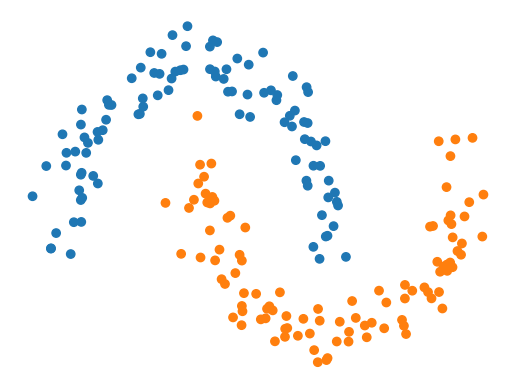

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

X, y = make_moons(n_samples=200, noise=0.1)
y_ = torch.unsqueeze(torch.tensor(y), 1)  # used for one-hot encoded labels
y_hot = torch.scatter(torch.zeros((200, 2)), 1, y_, 1)

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # colours for each class
plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

Defining a QNode
================

Our next step is to define the QNode that we want to interface with
`torch.nn`. Any combination of device, operations and measurements that
is valid in PennyLane can be used to compose the QNode. However, the
QNode arguments must satisfy additional `conditions
<code/api/pennylane.qnn.TorchLayer>`{.interpreted-text role="doc"}
including having an argument called `inputs`. All other arguments must
be arrays or tensors and are treated as trainable weights in the model.
We fix a two-qubit QNode using the
`default.qubit <code/api/pennylane.devices.default_qubit.DefaultQubit>`{.interpreted-text
role="doc"} simulator and operations from the
`templates <introduction/templates>`{.interpreted-text role="doc"}
module.


In [46]:
import pennylane as qml

n_qubits = 10
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
    qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
    qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
    qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
    qml.RandomLayers(weights, wires=range(n_qubits), ratio_imprim=0, rotations=[qml.RY], seed=42)
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]
weights = np.array([1,2,3,4,5,6,7,8,9,10]);

Interfacing with Torch
======================

With the QNode defined, we are ready to interface with `torch.nn`. This
is achieved using the `~pennylane.qnn.TorchLayer`{.interpreted-text
role="class"} class of the `~pennylane.qnn`{.interpreted-text
role="mod"} module, which converts the QNode to the elementary building
block of `torch.nn`: a *layer*. We shall see in the following how the
resultant layer can be combined with other well-known neural network
layers to form a hybrid model.

We must first define the `weight_shapes` dictionary. Recall that all of
the arguments of the QNode (except the one named `inputs`) are treated
as trainable weights. For the QNode to be successfully converted to a
layer in `torch.nn`, we need to provide the details of the shape of each
trainable weight for them to be initialized. The `weight_shapes`
dictionary maps from the argument names of the QNode to corresponding
shapes:


In [47]:
n_layers = 3
weight_shapes = {"weights": (n_layers, n_qubits)}

In our example, the `weights` argument of the QNode is trainable and has
shape given by `(n_layers, n_qubits)`, which is passed to
`~pennylane.templates.layers.BasicEntanglerLayers`{.interpreted-text
role="func"}.

Now that `weight_shapes` is defined, it is easy to then convert the
QNode:


In [48]:
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

With this done, the QNode can now be treated just like any other
`torch.nn` layer and we can proceed using the familiar Torch workflow.

Creating a hybrid model
=======================

Let\'s create a basic three-layered hybrid model consisting of:

1.  a 2-neuron fully connected classical layer
2.  our 2-qubit QNode converted into a layer
3.  another 2-neuron fully connected classical layer
4.  a softmax activation to convert to a probability vector

A diagram of the model can be seen in the figure below.

![](/demonstrations/qnn_module/qnn_torch.png){.align-center
width="100.0%"}

We can construct the model using the
[Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
API:


In [49]:
clayer_1 = torch.nn.Linear(2, 10)
clayer_2 = torch.nn.Linear(10, 2)
softmax = torch.nn.Softmax(dim=1)
layers = [clayer_1, qlayer, clayer_2, softmax]
model = torch.nn.Sequential(*layers)

Training the model
==================

We can now train our hybrid model on the classification dataset using
the usual Torch approach. We\'ll use the standard
[SGD](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)
optimizer and the mean absolute error loss function:


In [50]:
opt = torch.optim.SGD(model.parameters(), lr=0.2)
loss_func = torch.nn.L1Loss()

Note that there are more advanced combinations of optimizer and loss
function, but here we are focusing on the basics.

The model is now ready to be trained!


In [51]:
X = torch.tensor(X, requires_grad=True).float()
y_hot = y_hot.float()

batch_size = 5
batches = 200 // batch_size

train_dataset = TensorDataset(X, y_hot)
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, drop_last=True)

epochs = 6

for epoch in range(epochs):
    train_running_loss = 0

    for xs, ys in train_loader:
        opt.zero_grad()

        loss_evaluated = loss_func(model(xs), ys)
        loss_evaluated.backward()

        opt.step()

        train_running_loss += loss_evaluated.item()

    train_avg_loss = train_running_loss / batches
    print(f"Train - Epoch {epoch + 1}: Loss: {train_avg_loss:.4f}")

    # Calculate train accuracy
    y_pred_train = model(X)
    predictions_train = torch.argmax(y_pred_train, axis=1).detach().numpy()

    correct_train = [1 if p == p_true else 0 for p, p_true in zip(predictions_train, y)]
    train_accuracy = sum(correct_train) / len(correct_train)
    print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

    # Calculate test loss and accuracy
    test_loss = loss_func(model(X), y_hot).item()
    print(f"Test - Epoch {epoch + 1}: Loss: {test_loss:.4f}")

    y_pred_test = model(X)
    predictions_test = torch.argmax(y_pred_test, axis=1).detach().numpy()

    correct_test = [1 if p == p_true else 0 for p, p_true in zip(predictions_test, y)]
    test_accuracy = sum(correct_test) / len(correct_test)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Train - Epoch 1: Loss: 0.1583
Train Accuracy: 94.00%
Test - Epoch 1: Loss: 0.0898
Test Accuracy: 94.00%
Train - Epoch 2: Loss: 0.0729
Train Accuracy: 98.50%
Test - Epoch 2: Loss: 0.0516
Test Accuracy: 98.50%
Train - Epoch 3: Loss: 0.0408
Train Accuracy: 99.50%
Test - Epoch 3: Loss: 0.0308
Test Accuracy: 99.50%
Train - Epoch 4: Loss: 0.0291
Train Accuracy: 99.00%
Test - Epoch 4: Loss: 0.0242
Test Accuracy: 99.00%
Train - Epoch 5: Loss: 0.0244
Train Accuracy: 99.50%
Test - Epoch 5: Loss: 0.0194
Test Accuracy: 99.50%
Train - Epoch 6: Loss: 0.0198
Train Accuracy: 99.00%
Test - Epoch 6: Loss: 0.0187
Test Accuracy: 99.00%


How did we do? The model looks to have successfully trained and the
accuracy is reasonably high. In practice, we would aim to push the
accuracy higher by thinking carefully about the model design and the
choice of hyperparameters such as the learning rate.

Creating non-sequential models
==============================

The model we created above was composed of a sequence of classical and
quantum layers. This type of model is very common and is suitable in a
lot of situations. However, in some cases we may want a greater degree
of control over how the model is constructed, for example when we have
multiple inputs and outputs or when we want to distribute the output of
one layer into multiple subsequent layers.

Suppose we want to make a hybrid model consisting of:

1.  a 4-neuron fully connected classical layer
2.  a 2-qubit quantum layer connected to the first two neurons of the
    previous classical layer
3.  a 2-qubit quantum layer connected to the second two neurons of the
    previous classical layer
4.  a 2-neuron fully connected classical layer which takes a
    4-dimensional input from the combination of the previous quantum
    layers
5.  a softmax activation to convert to a probability vector

A diagram of the model can be seen in the figure below.

![](/demonstrations/qnn_module/qnn2_torch.png){.align-center
width="100.0%"}

This model can also be constructed by creating a new class that inherits
from the `torch.nn`
[Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module) and
overriding the `forward()` method:


In [52]:
class HybridModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.clayer_1 = torch.nn.Linear(2, 10)
        self.qlayer_1 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.clayer_2 = torch.nn.Linear(10, 2)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.clayer_1(x)
        x = self.qlayer_1(x)
        x = self.clayer_2(x)
        return self.softmax(x)

model = HybridModel()

As a final step, let\'s train the model to check if it\'s working:


In [53]:
opt = torch.optim.SGD(model.parameters(), lr=0.2)
epochs = 6

for epoch in range(epochs):
    train_running_loss = 0

    for xs, ys in train_loader:
        opt.zero_grad()

        loss_evaluated = loss_func(model(xs), ys)
        loss_evaluated.backward()

        opt.step()

        train_running_loss += loss_evaluated.item()

    train_avg_loss = train_running_loss / batches
    print(f"Train - Epoch {epoch + 1}: Loss: {train_avg_loss:.4f}")

    # Calculate train accuracy
    y_pred_train = model(X)
    predictions_train = torch.argmax(y_pred_train, axis=1).detach().numpy()

    correct_train = [1 if p == p_true else 0 for p, p_true in zip(predictions_train, y)]
    train_accuracy = sum(correct_train) / len(correct_train)
    print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

    # Calculate test loss and accuracy
    test_loss = loss_func(model(X), y_hot).item()
    print(f"Test - Epoch {epoch + 1}: Loss: {test_loss:.4f}")

    y_pred_test = model(X)
    predictions_test = torch.argmax(y_pred_test, axis=1).detach().numpy()

    correct_test = [1 if p == p_true else 0 for p, p_true in zip(predictions_test, y)]
    test_accuracy = sum(correct_test) / len(correct_test)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Train - Epoch 1: Loss: 0.2340
Train Accuracy: 94.50%
Test - Epoch 1: Loss: 0.1095
Test Accuracy: 94.50%
Train - Epoch 2: Loss: 0.0840
Train Accuracy: 96.00%
Test - Epoch 2: Loss: 0.0684
Test Accuracy: 96.00%
Train - Epoch 3: Loss: 0.0519
Train Accuracy: 99.50%
Test - Epoch 3: Loss: 0.0374
Test Accuracy: 99.50%
Train - Epoch 4: Loss: 0.0354
Train Accuracy: 98.00%
Test - Epoch 4: Loss: 0.0323
Test Accuracy: 98.00%
Train - Epoch 5: Loss: 0.0304
Train Accuracy: 98.50%
Test - Epoch 5: Loss: 0.0276
Test Accuracy: 98.50%
Train - Epoch 6: Loss: 0.0261
Train Accuracy: 99.50%
Test - Epoch 6: Loss: 0.0190
Test Accuracy: 99.50%


Great! We\'ve mastered the basics of constructing hybrid
classical-quantum models using PennyLane and Torch. Can you think of any
interesting hybrid models to construct? How do they perform on realistic
datasets?


About the author
================


In [54]:
seconds = time.time()
print("Time in seconds since end of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since end of run: 1704175522.6618652
Tue Jan  2 06:05:22 2024
